In [1]:
import numpy as np
from numpy.linalg import norm

In [2]:
import os
import time


In [3]:
import pickle


In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [5]:
model = VGG16(weights='imagenet', include_top=False, input_shape =(224, 224, 3))


In [6]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features
    

In [7]:
features = extract_features('data/tops/top1.jpeg', model)
print(len(features))

25088


In [8]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [44]:
root_dir = 'data/training'
filenames = sorted(get_file_list(root_dir))

In [45]:
feature_list = []
for i in range(len(filenames)):
    feature_list.append(extract_features(filenames[i], model))

In [17]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

In [16]:
pickle.dump(feature_list, open('data/features-vgg16.pickle', 'wb'))
pickle.dump(filenames, open('data/filenames-vgg16.pickle','wb'))

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

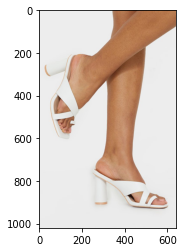

In [15]:
plt.imshow(mpimg.imread(filenames[0]))


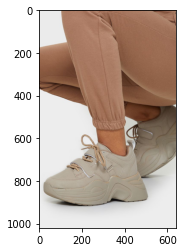

In [16]:
plt.imshow(mpimg.imread(filenames[1]))

In [17]:
from sklearn.decomposition import PCA

In [18]:
from sklearn.manifold import TSNE

[t-SNE] Computing 69 nearest neighbors...
[t-SNE] Indexed 70 samples in 0.000s...
[t-SNE] Computed neighbors for 70 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 70 / 70
[t-SNE] Mean sigma: 0.276332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.277397
[t-SNE] KL divergence after 1000 iterations: 0.305624


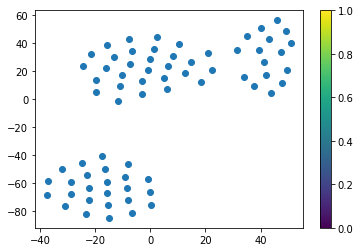

In [52]:
# Perform PCA over the features
num_feature_dimensions=2 # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:70]
#selected_class_ids = class_ids[:150]
selected_filenames = filenames[:70]

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1],cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

In [21]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

In [22]:
from PIL import Image

In [23]:
def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()

In [54]:
def show_tsne(x, y, selected_filenames):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=1.5, axis=axis)
    plt.show()

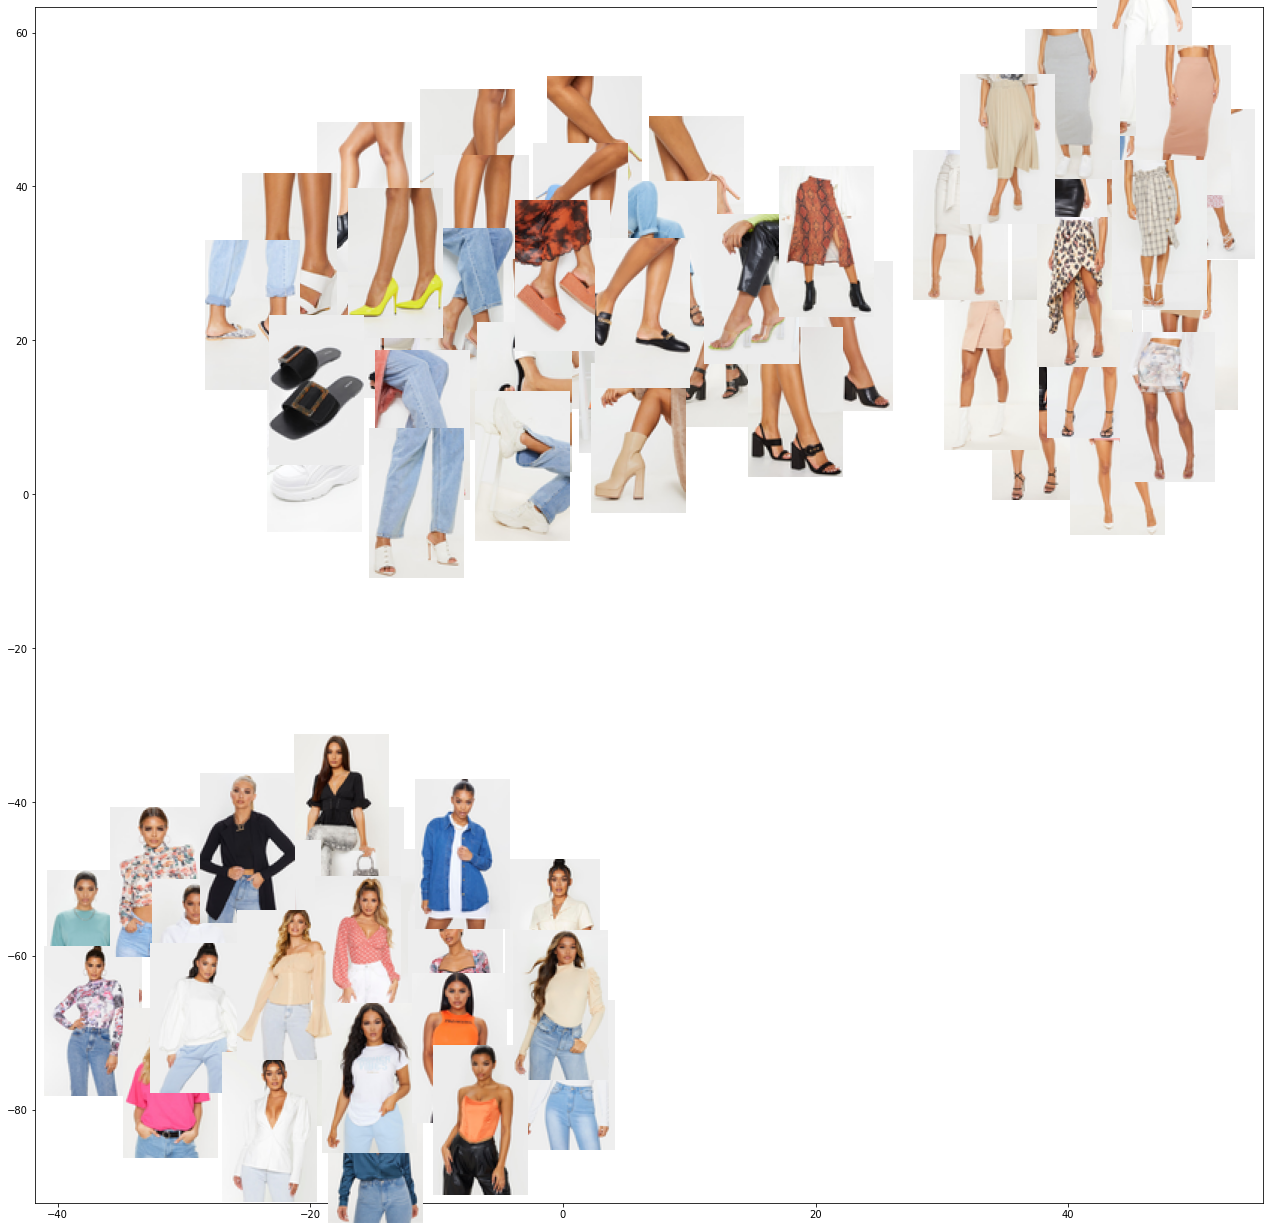

In [55]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], selected_filenames)

In [48]:
print(len(feature_list))

99
